# GIS Example File
This file serves as an example for the GIS handler used to integrate GIS data with Python models. The handler can be loaded from the cell below, for use in a notebook, or from the `gis_handler.py` file which is identical. The examples in this file demonstrate possible ways to use the handler in modeling.

## Setup

In [1]:
# import packages required for the examples
import matplotlib.pyplot as plt
import rasterio.plot

In [2]:
# specify plot settings such as figure size
plt.rcParams["figure.figsize"] = [10,8]
%config InlineBackend.figure_format = 'retina'

## Handler

In [3]:
# Python GIS Handler
# SEA Lab at Cornell University, last updated: 4/24/23

# import necessary packages, namely geopandas and rasterio
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning

# ignore shapely 1.8 deprecation warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
precision = 5 # precision of input coordinates to prevent duplicate calls, 5dec~1.1m

class GISHandler:
    """A class to handle GIS data and optimizer points."""
        
    def __init__(self, conditions, conflicts, scope):
        """Initializes handler by creating a GeoDataFrame to store point measurement data and a dictionary of loaded raster files."""
        self.conditions = {}
        self.conflicts = {}
        self.scope = gpd.read_file(scope)
        # create initial geodataframe with anticipated fields
        self.points = gpd.GeoDataFrame(columns=['x', 'y', 'geometry', 'result', 'ok-conditions', 'ok-scope', 'ok-conflicts'], geometry='geometry')
    
        # check if raster already loaded as a condition, otherwise read source
        for key, src in conditions.items():
            if key in self.conditions:
                print('raster {} already loaded!'.format(key))
            else:
                self.conditions[key] = rasterio.open(src)
        
        # check if vector already loaded as a conflict, otherwise read source
        for key, src in conflicts.items():
            if key in self.conflicts:
                print('vector {} already loaded!'.format(key))
            else:
                self.conflicts[key] = gpd.read_file(src)
                
        # calculate boundaries of loaded files
        self.extent = self.extent()
    
    def query(self, x, y):
        """Gets condition data for a specified geography location (lon/lat), stores it in the GeoDataFrame, and returns the row."""
        x, y = self.coordinate(x, y)
                                
        # check if point has already been queried
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            print('point exists, returning original data')
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        point = Point(x, y)
        conditions = {'x': x, 'y': y, 'geometry': point, 'ok-conditions': True, 'ok-scope': False, 'ok-conflicts': True}
        
        # check if point is offshore in desired scope
        for polygon in self.scope['geometry']:
            if point.intersects(polygon):
                conditions['ok-scope'] = True
        
        # check if point intersects with any of the conflicts loaded as vectors
        for key, vector in self.conflicts.items():
            for polygon in vector['geometry']:
                if point.intersects(polygon):
                    conditions['ok-conflicts'] = False
        
        # check if point exists for all condition datasets, and pull condition data for point
        for key, raster in self.conditions.items():
            index = raster.index(x, y)
            try:
                 conditions[key] = raster.read(1)[index] # yes, by default this only reads the first band, but this is probably okay
            except IndexError as error:
                print('failed to read {} raster: {}'.format(key, error))
            if conditions[key] == 0: # yes, this assumes that zero is not a valid value. this is true for our current rasters, but isn't necessarily correct
                conditions['ok-conditions'] = False
        
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]
    
    def record(self, x, y, value):
        """Records a computed value from the optimizer to a geographic point, returns row recorded to."""
        x, y = self.coordinate(x, y)
        
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            self.points.loc[(self.points.x==x) & (self.points.y==y), 'result'] = value
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y), 'result': value}
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]
    
    def query_grid(self, x_min, x_max, y_min, y_max, xy_delta):
        """Iteratively builds a grid of points with desired bounds and resolution for brute-force analysis."""
        self.grid = gpd.GeoDataFrame(columns=['x', 'y', 'geometry', 'result', 'ok-conditions', 'ok-scope', 'ok-conflicts'], geometry='geometry')
        
        x = x_min
        y = y_min
        while x <= x_max:
            while y <= y_max:
                self.query(x, y)
                y += xy_delta
            y=y_min
            x += xy_delta
    
    def save(self, name):
        """Saves all loaded points and values into GIS format."""
        self.points.to_file(name, driver='GeoJSON')
        
    def load(self, name):
        """Loads previously saved points from GIS file."""
        self.points = gpd.read_file(name)
        
    def coordinate(self, x, y):
        """Rounds coordinates to given precision to prevent uneccessary duplication. In the future could handle projections."""
        return round(x, precision), round(y, precision)
    
    def extent(self):
        """Calculates largest rectangular extent that includes data from all loaded rasters."""
        
        extent = [-180, 180, -90, 90] # format: [W, E, S, N]
        for src in self.conditions.values():
            extent = [max(extent[0], src.bounds[0]), min(extent[1], src.bounds[2]), max(extent[2], src.bounds[1]), min(extent[3], src.bounds[3])]
            
        return extent

## Example Usage

### Load conditions (rasters), conflicts (vectors), and scope (vector)

In [4]:
# specify raster files with conditions
conditions = {'current [m/s]': '../../data/Surface Current (m-s).tif',
              'oxygen [mg/l]': '../../data/Surface Oxygen (mg-l).tif',
              'salinity [PSU]': '../../data/Surface Salinity (PSU).tif',
              'temperature [°C]': '../../data/Surface Temperature (C).tif',
              'period [s]': '../../data/Wave Energy Period (s).tif',
              'height [m]': '../../data/Wave Significant Height (m).tif',
              'bathymetry [m]': '../../data/Bathymetry (m).tif',
              'distance to port [m]': '../../data/Distance to Port (m).tif'}

# specify vector files with conflicts
# high fishing is above average, very high is more than one standard deviation above average
conflicts = {'very high fishing traffic': '../../data/Very High Fishing Vessel Traffic.geojson',
#            'high fishing traffic': 'data/High Fishing Vessel Traffic.geojson',
             'marine protected areas': '../../data/Marine Protected Areas.geojson',
             'danger zones': '../../data/Danger Zones and Restricted Areas.geojson',
             'submarine': '../../data/Submarine Transit Lanes.geojson',
             'torpex': '../../data/Cape Cod TORPEX.geojson',
             'block island': '../../data/Block Island Renewable Energy Zone.geojson',
             'ma wind': '../../data/MA Wind Energy Areas.geojson',
             'wind lease': '../../data/Potential Wind Lease Areas.geojson',
             'wind planning': '../../data/Wind Planning Areas.geojson',
             'shipping': '../../data/Shipping Lanes.geojson'}

# specify vector file with desired scope
waters = "../../data/Northeast State and Federal Waters.geojson"

# create handler object given specified files to load
handler = GISHandler(conditions, conflicts, waters)

### Basic Operations

#### Print Extent

In [5]:
print('Extent: W', handler.extent[0], 'E', handler.extent[1], 'S', handler.extent[2], 'N', handler.extent[3])

Extent: W -75.105000333 E -65.701105095 S 38.4486345 N 45.190902453


#### Query Point in Format (longitude, latitude) to Get Data

In [6]:
handler.query(-70.154, 42.203)

,x,y,geometry,result,ok-conditions,ok-scope,ok-conflicts,bathymetry [m],current [m/s],distance to port [m],height [m],oxygen [mg/l],period [s],salinity [PSU],temperature [°C]
0,-70.154,42.203,POINT (-70.15400 42.20300),NaN,True,True,False,-41.900002,0.125274,75671.992188,0.88,9.504469,5.71,31.597025,10.295712


In [7]:
handler.query(-72, 41.2)

,x,y,geometry,result,ok-conditions,ok-scope,ok-conflicts,bathymetry [m],current [m/s],distance to port [m],height [m],oxygen [mg/l],period [s],salinity [PSU],temperature [°C]
1,-72.0,41.2,POINT (-72.00000 41.20000),NaN,True,True,True,-29.299999,0.278167,76787.039062,0.42,9.262932,5.69,29.115828,11.720197


#### Record Result of Model into GeoDataFrame

In [8]:
# example result from model: 10
handler.record(-72, 41.2, 10)

,x,y,geometry,result,ok-conditions,ok-scope,ok-conflicts,bathymetry [m],current [m/s],distance to port [m],height [m],oxygen [mg/l],period [s],salinity [PSU],temperature [°C]
1,-72.0,41.2,POINT (-72.00000 41.20000),10.0,True,True,True,-29.299999,0.278167,76787.039062,0.42,9.262932,5.69,29.115828,11.720197


#### Generate a Grid of Points

In [9]:
%%time
handler.query_grid(-75.8, -65.7, 38.5, 45.2, 1)

CPU times: user 5.1 s, sys: 372 ms, total: 5.47 s
Wall time: 5.49 s


#### Save Results to File

In [10]:
handler.save('saved.geojson')

### Show Results with Tables and Maps

In [11]:
handler.points

,x,y,geometry,result,ok-conditions,ok-scope,ok-conflicts,bathymetry [m],current [m/s],distance to port [m],height [m],oxygen [mg/l],period [s],salinity [PSU],temperature [°C]
0,-70.154,42.203,POINT (-70.15400 42.20300),NaN,True,True,False,-41.900002,0.125274,7.567199e+04,0.88,9.504469e+00,5.71,31.597025,10.295712
1,-72.000,41.200,POINT (-72.00000 41.20000),10.0,True,True,True,-29.299999,0.278167,7.678704e+04,0.42,9.262932e+00,5.69,29.115828,11.720197
2,-75.800,38.500,POINT (-75.80000 38.50000),NaN,False,False,True,0.000000,0.000000,-3.402823e+38,0.00,-3.402823e+38,0.00,NaN,0.000000
3,-75.800,39.500,POINT (-75.80000 39.50000),NaN,False,False,True,0.000000,0.000000,-3.402823e+38,0.00,-3.402823e+38,0.00,NaN,0.000000
4,-75.800,40.500,POINT (-75.80000 40.50000),NaN,False,False,True,0.000000,0.000000,-3.402823e+38,0.00,-3.402823e+38,0.00,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,-65.800,40.500,POINT (-65.80000 40.50000),NaN,False,True,True,0.000000,0.046522,4.702021e+05,0.00,8.779799e+00,0.00,34.423477,16.184963
75,-65.800,41.500,POINT (-65.80000 41.50000),NaN,False,False,True,0.000000,0.000000,-3.402823e+38,0.00,-3.402823e+38,0.00,NaN,0.000000
76,-65.800,42.500,POINT (-65.80000 42.50000),NaN,False,False,True,0.000000,0.000000,-3.402823e+38,0.00,-3.402823e+38,0.00,NaN,0.000000
77,-65.800,43.500,POINT (-65.80000 43.50000),NaN,False,False,True,0.000000,0.000000,-3.402823e+38,0.00,-3.402823e+38,0.00,NaN,0.000000


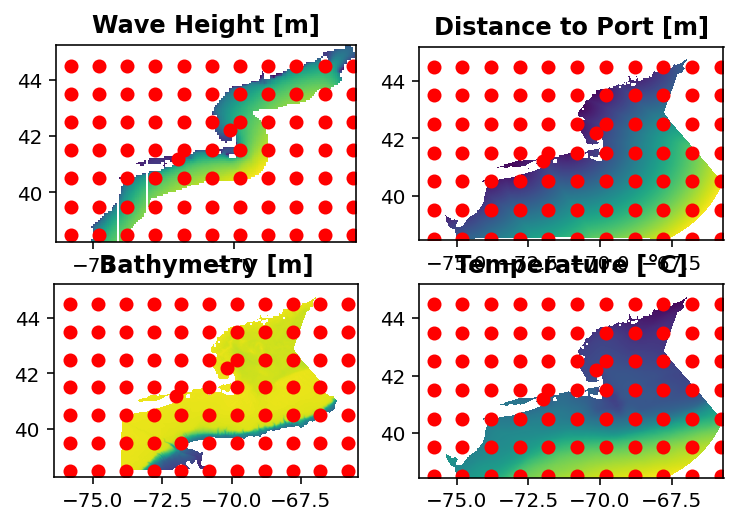

In [12]:
fig, ax = plt.subplots(2, 2)
rasterio.plot.show(handler.conditions['height [m]'], ax=ax[0,0], title='Wave Height [m]')
rasterio.plot.show(handler.conditions['distance to port [m]'], ax=ax[0,1], title='Distance to Port [m]')
rasterio.plot.show(handler.conditions['bathymetry [m]'], ax=ax[1,0], title='Bathymetry [m]')
rasterio.plot.show(handler.conditions['temperature [°C]'], ax=ax[1,1], title='Temperature [°C]')

for i in ax:
    for j in i:
        handler.points.plot(ax=j, color='red')

CPU times: user 2.83 s, sys: 11.1 ms, total: 2.84 s
Wall time: 2.85 s


<AxesSubplot: >

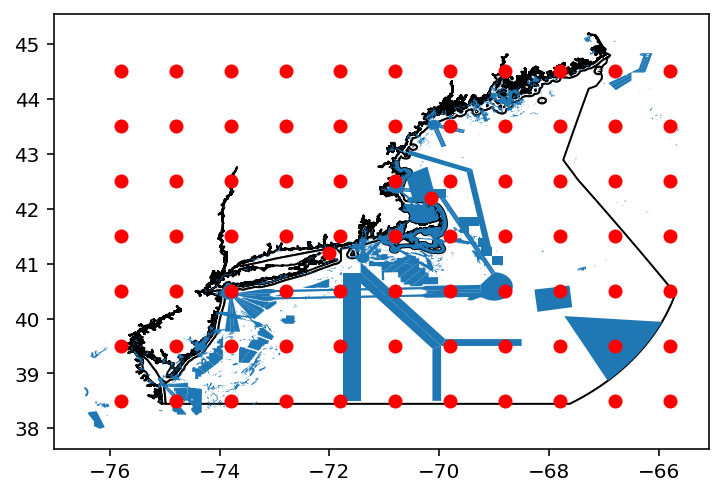

In [13]:
%%time
fig, ax = plt.subplots()
handler.scope.plot(edgecolor='black', color='white', ax=ax)
for gdf in handler.conflicts.values():
    gdf.plot(ax=ax)
handler.points.plot(ax=ax, color='red')